# Rental cars - Price optimization

# Analysis, Modeling, Math, etc.

For this business case, its not just optimizing the host's revenue, finding the most optimal price that a guest would book a car and complete the transaction

Its not just determining the optimal price at which the car is listed, we should price the car to provide a fair price to the guest but also maximize host's and our own profits. So we need to suggest a price based on market demand and car true value and other categories in such a way that, guest would have high chances to reserve a car

In this notebook, I have used XGBoost Regressor & XGBoost Classifier for prices & is_booked predictions

First of all, using the given historical data, i have build a regression model in predicting the price using all the given listing inputs. 
And i have modelled a classification on is_booked, using all other listing variables including price

Now i have followed  the below steps to find the optial price:

Step1:
Predict the price using our existing regression model

Step 2:
Using this predicted price and other variables, predict if the guest is going to book or not (var - 'is_booked')

Step 3:
(Finding the optimal price)
if yes (is_booked ==1) , Try to increase the price by 1 unit in each iteration, and see whats the maximum price that we can list it in order to get it booked 
if No (is_booked == 0) , Try to decrease the price by 1 unit in each iteration, and see whats the best highest price that the guest would book the listing 

Step 4:
Repeat the step 2 using the optial price gained from the above step to see if the guest is going to book or not

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import holidays
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [51]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [52]:
df = pd.read_csv('vehicles_booking_history.csv')
df_cpy = df
df.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price
0,333483,2018-05-25,0,14569,midsize,1.902318,30.0
1,304273,2018-05-12,1,4201,compact,14.622831,39.0
2,298081,2018-04-07,1,5724,midsize,8.659708,24.0
3,406331,2018-12-31,1,39102,suv,13.570390,121.0
4,456223,2018-08-09,0,9666,midsize,1.297453,42.0


In [53]:
df.describe()

,vehicle_id,is_booked,tmv,demand_supply_ratio,price
count,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000
mean,351141.568783,0.537566,14136.074603,6.043046,45.396825
std,88018.990982,0.498719,9340.612268,3.951393,22.193485
min,174075.000000,0.000000,3875.000000,0.463101,10.000000
25%,298081.000000,0.000000,7115.000000,3.002744,30.000000
50%,333483.000000,1.000000,10850.000000,5.694339,39.000000
75%,416371.000000,1.000000,18802.000000,8.431289,52.000000
max,535905.000000,1.000000,39102.000000,23.333333,134.000000


Adding feature variables

In [54]:
us_holidays = holidays.US(years=[2018,2019])
df['is_holiday'] = pd.to_datetime(df['date']).dt.date.astype('datetime64').isin(us_holidays).astype(int)
df['weekday'] = pd.to_datetime(df['date']).dt.dayofweek
df['is_weekend'] = (df['weekday'] // 5 == 1).astype(int)
df['month'] = pd.DatetimeIndex(df['date']).month

Checking the skewness

Text(0.5, 1.0, 'Price Distribution')

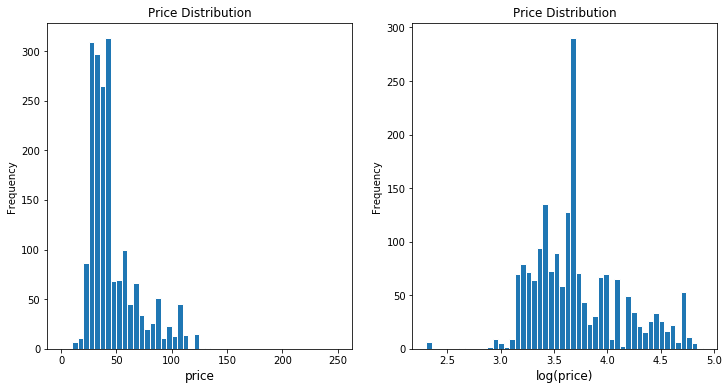

In [55]:
plt.subplot(1, 2, 1)
(df['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(df['price']).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

Checking for class imbalances

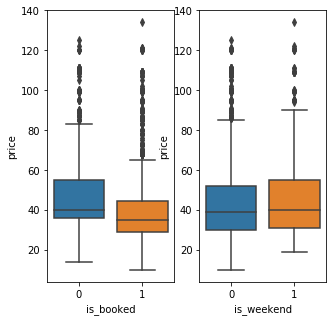

In [56]:
plt.subplot(1, 2, 1)
sns.boxplot(x= 'is_booked',y = 'price',data = df)
plt.subplot(1, 2, 2)
sns.boxplot(x= 'is_weekend',y = 'price',data = df)

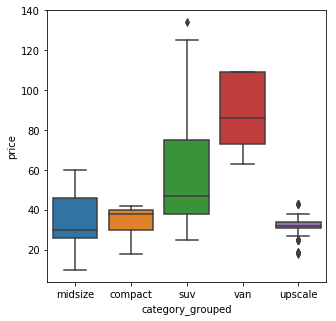

In [57]:
sns.boxplot(x= 'category_grouped',y = 'price',data = df)

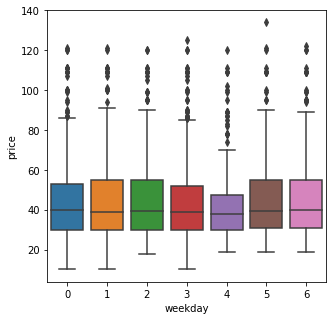

In [58]:
sns.boxplot(x= 'weekday',y = 'price',data = df)

In [59]:
df = pd.get_dummies(df, columns = ['category_grouped','month','weekday'], prefix = ['cat','month','weekday'],drop_first=True)

In [60]:
df = df.drop(['vehicle_id','date'], axis=1)

In [61]:
df.isnull().values.any()

False

Text(0.5, 1.0, 'Heatmap of Correlation')

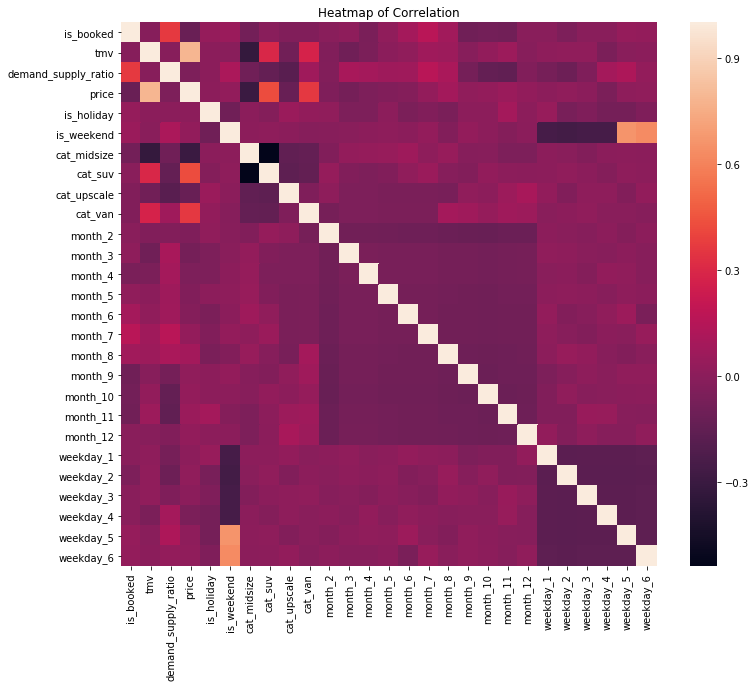

In [62]:
#heatmap after accouting for correlation
corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Heatmap of Correlation')

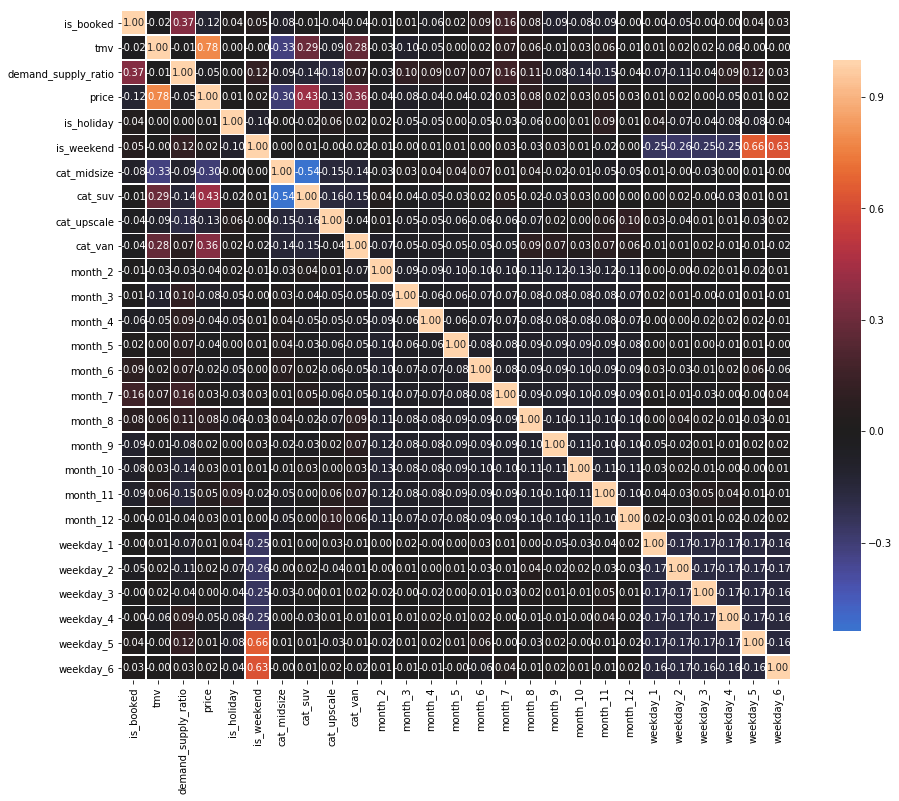

In [63]:
def correlation_heatmap(train):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df)

In [64]:
df = df.drop(['cat_suv','is_weekend'], axis=1)

# Regression Model - Price Prediction

In [65]:
df = df.drop(['is_booked'], axis=1)

Bins creation & max-min bounds of price in each category

In [70]:
df['binned_dsr']  = pd.cut(df['demand_supply_ratio'], 5, labels=[1,2,3,4,5])
df['binned_tmv']  = pd.cut(df['tmv'], 5, labels=[1,2,3,4,5])

df['price_max'] = df.groupby(['binned_dsr','binned_tmv'])['price'].transform(max)
df['price_min'] = df.groupby(['binned_dsr','binned_tmv'])['price'].transform(min)

df_test['price_max'] = df['price_max'].astype(int)
df_test['price_min'] = df['price_min'].astype(int)

In [67]:
X_reg = df.drop('price', axis=1)
y_reg = df[['price']]

# Split X and y into X_
X_train_cpy, X_test_cpy, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=1)

X_train_reg = X_train_cpy.drop(columns = ['binned_dsr','binned_tmv','price_max','price_min'], axis=1)
X_test_reg = X_test_cpy.drop(columns = ['binned_dsr','binned_tmv','price_max','price_min'], axis=1)
X_reg = X_reg.drop(columns = ['binned_dsr','binned_tmv','price_max','price_min'], axis = 1)
df = df.drop(columns = ['binned_dsr','binned_tmv','price_max','price_min'], axis = 1)


Grid Search Algorithm to find the best parameters

In [25]:
gbm_param_grid = {
     'colsample_bytree': np.linspace(0.5, 0.9, 5),
     'n_estimators':[100, 200],
     'max_depth': [10, 15, 20, 25]
}
gbm = xgb.XGBRegressor()
grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)
grid_mse.fit(X_train_reg, y_train_reg)
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.0min finished


Best parameters found:  {'colsample_bytree': 0.9, 'max_depth': 15, 'n_estimators': 100}
Lowest RMSE found:  5.735071086488344


Regression Model - Fit

In [26]:
reg_model = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.05, reg_lambda = 100, 
                max_depth = 5, n_estimators = 200)
reg_model.fit(X_train_reg,y_train_reg)

from sklearn.metrics import r2_score

y_pred_reg = reg_model.predict(X_train_reg)
print('Train r2_score:',r2_score(y_train_reg, y_pred_reg))

y_pred_reg = reg_model.predict(X_test_reg)
print('Test r2_score:',r2_score(y_test_reg, y_pred_reg))


# Cross - Validation with 10 folds
cv_results = cross_val_score(reg_model, X_train_reg, y_train_reg, cv=10, scoring='r2')
print('Cross validation score: ', cv_results.mean())


Train r2_score: 0.9040817638924513
Test r2_score: 0.8757573517253578
Cross validation score:  0.8830326886550426


In [27]:
data_dmatrix = xgb.DMatrix(data=X_reg,label=y_reg)
params = {"objective":"reg:linear",'colsample_bytree': 0.9,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,45.265198,0.188883,45.266313,0.405822
1,41.069378,0.249850,41.088071,0.479236
2,37.169071,0.229093,37.194098,0.479033
3,33.669833,0.205915,33.695526,0.471161
4,30.527122,0.183532,30.569466,0.455123


In [28]:
print((cv_results["test-rmse-mean"]).tail(1))

49    6.346735
Name: test-rmse-mean, dtype: float64


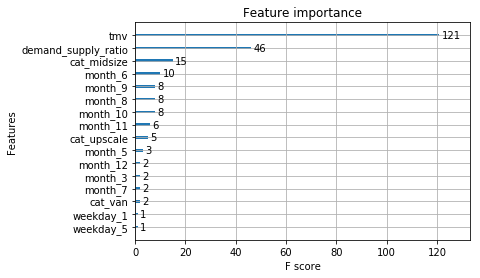

In [29]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# Classification Model - Is booked / Not

In [30]:
df['price'] = np.log(df['price'])
df['is_booked'] = df_cpy['is_booked']
df = df.drop('tmv',axis = 1)
X_clf = df.drop('is_booked', axis=1)
y_clf = df[['is_booked']]

# Train-Test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.25, random_state=1)

df_test = pd.DataFrame()
df_test['actual_price'] = np.exp(X_test_clf['price']).astype(int)
df_test['actual_is_booked'] = y_test_clf['is_booked']

Model Selection

In [31]:
##Comparing different Classification models

models = []

models.append(('LR', LogisticRegression()))
models.append(('XGB', XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators = 100)))
models.append(('RF', RandomForestClassifier(max_depth = 10, n_estimators = 100)))

#testing models
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=1)
    cv_results = cross_val_score(model, X_train_clf, y_train_clf, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = '%s: Accuracy is  %f (Standard Error: %f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: Accuracy is  0.685906 (Standard Error: 0.033421)
XGB: Accuracy is  0.808725 (Standard Error: 0.021977)
RF: Accuracy is  0.784727 (Standard Error: 0.022866)


Grid-Search to find the best parameters

In [32]:
gbm_param_grid = {
     'colsample_bytree': np.linspace(0.5, 0.9, 5),
     'n_estimators':[100, 200],
     'max_depth': [10, 15, 20, 25]
}

In [33]:
gbm = xgb.XGBClassifier()
grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'accuracy', cv = 5, verbose = 1)

In [34]:
grid_mse.fit(X_train_clf, y_train_clf)
print("Best parameters found: ",grid_mse.best_params_)
print("Accuracy found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished


Best parameters found:  {'colsample_bytree': 0.9, 'max_depth': 20, 'n_estimators': 100}
Accuracy found:  0.9075080850815356


Fitting the model

In [35]:
from sklearn.metrics import accuracy_score

#Fitting the model with Logistic Regression
clf_model = XGBClassifier(colsample_bytree = 0.9,learning_rate = 0.2, max_depth = 20, reg_lambda = 100, n_estimators = 100)

clf_model.fit(X_train_clf,y_train_clf)

y_prob_both = clf_model.predict_proba(X_test_clf)
y_prob_clf = y_prob_both[:,1]

y_pred_clf = clf_model.predict(X_train_clf)
print('Train Accuracy:', accuracy_score(y_train_clf, y_pred_clf))

y_pred_clf = clf_model.predict(X_test_clf)
print('Test Accuracy:', accuracy_score(y_test_clf, y_pred_clf))

# Cross - Validation with 10 folds
cv_results = cross_val_score(clf_model, X_train_clf, y_train_clf, cv=10, scoring='accuracy')
print('Cross validation score: ', cv_results.mean())

Train Accuracy: 0.8828510938602682
Test Accuracy: 0.8350951374207188
Cross validation score:  0.8009869857442528


In [36]:
#Confusion Matrix for the above classification
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_clf, y_pred_clf)
print(confusion_matrix)

[[172  44]
 [ 34 223]]


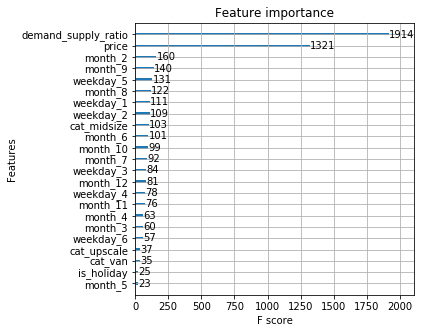

In [37]:
#Observing the feature importance
import xgboost as xgb
xgb.plot_importance(clf_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## Recommendation function

In [171]:
X_sam = df_cpy.drop('price', axis=1)
y_sam = df_cpy[['price']]

X_train_sam, X_test_sam, y_train_sam, y_test_sam = train_test_split(X_sam, y_sam, test_size=0.25, random_state=1)
inp_df = pd.DataFrame(X_test_sam, columns = ['tmv', 'demand_supply_ratio','date','category_grouped'])
inp_df.head()

,tmv,demand_supply_ratio,date,category_grouped
1723,18150,10.769470,2018-03-20,compact
1847,9666,0.958582,2018-10-22,midsize
1407,39102,15.928629,2018-07-29,suv
655,12149,7.575510,2018-04-06,midsize
102,39102,15.406526,2018-07-03,suv


In [172]:
df_test['price_min'] = X_test_cpy['price_min'].astype(int)
df_test['price_max'] = X_test_cpy['price_max'].astype(int)
df_test['actual_price'] = df_cpy['price'].astype(int)
df_test['actual_is_booked'] = df_cpy['is_booked']


In [183]:
def transform_data(inp_df):
    us_holidays = holidays.US(years=[2018,2019])
    inp_df['is_holiday'] = pd.to_datetime(inp_df['date']).dt.date.astype('datetime64').isin(us_holidays).astype(int)
    inp_df['weekday'] = pd.to_datetime(inp_df['date']).dt.dayofweek
    inp_df['month'] = pd.DatetimeIndex(inp_df['date']).month
    inp_df = pd.get_dummies(inp_df, columns = ['category_grouped','month','weekday'], prefix = ['cat','month','weekday'],drop_first=True)
    inp_df = inp_df.drop(['date','cat_suv'], axis = 1)
    trans_df = inp_df.copy()
    return trans_df

In [192]:
def get_optimal_prices(inp_df): 
    trans_df = transform_data(inp_df)
    y_pred_reg = reg_model.predict(trans_df)
    
    #classification of is_booked using predicted price
    X_test_clf['price'] = np.log(y_pred_reg.astype(int))
    y_prob_both = clf_model.predict_proba(X_test_clf)
    y_prob_clf = y_prob_both[:,1]
    #We can change the threshold here from 0.5 to 0.4/0.6 in order control false neghatives and false positives
    y_pred_clf = [1 if i> 0.5 else 0 for i in y_prob_clf]
    
    #collection of results in 'df_test' dataframe
    df_test['pred_price'] = y_pred_reg.astype(int)
    df_test['pred_is_booked'] = y_pred_clf

    df_test['optimal_price'] = ""
    
    # Optimization Logic
    for i in range(0, len(X_test_clf)):
        X_sample_test = pd.DataFrame(X_test_clf.iloc[i]).T
        opt_flag = 0
        is_booked_flag = 0
        j_prev = 0
        if df_test['pred_is_booked'].iloc[i] == 0:
            for j in range(df_test['pred_price'].iloc[i]+5, df_test['price_min'].iloc[i], -1):
                price_set = j
                X_sample_test['price'].iloc[0] = np.log(price_set)
                y_pred_var = clf_model.predict(X_sample_test)
                if y_pred_var == 1:
                    df_test['optimal_price'].iloc[i] = j
                    opt_flag = 1
                    break
        else:
            for j in range(df_test['pred_price'].iloc[i], df_test['price_max'].iloc[i]+5, +1):
                is_booked_flag = 1
                price_set = j
                X_sample_test['price'].iloc[0] = np.log(price_set)
                y_pred_var = clf_model.predict(X_sample_test)
                if y_pred_var == 0:
                    df_test['optimal_price'].iloc[i] = j_prev
                    opt_flag = 1
                    break
                j_prev = j
        if opt_flag == 0:
            if is_booked_flag ==1:
                df_test['optimal_price'].iloc[i] = df_test['price_max'].iloc[i]
            else:    
                df_test['optimal_price'].iloc[i] = df_test['pred_price'].iloc[i]
    
    #Classification using optimal prices
    X_test_clf['price'] = np.log(df_test['optimal_price'])
    y_pred_clf = clf_model.predict(X_test_clf)
    df_test['optimal_is_booked'] = y_pred_clf.astype(int)
    trans_df_opt = pd.DataFrame(inp_df, columns = ['tmv','demand_supply_ratio','date','category_grouped'])
    trans_df_opt['optimal_price'] = df_test['optimal_price']
    return trans_df_opt;

In [193]:
trans_df_opt = get_optimal_prices(inp_df)

In [194]:
trans_df_opt.head(10)

,tmv,demand_supply_ratio,date,category_grouped,optimal_price
1723,18150,10.769470,2018-03-20,compact,45
1847,9666,0.958582,2018-10-22,midsize,48
1407,39102,15.928629,2018-07-29,suv,134
655,12149,7.575510,2018-04-06,midsize,48
102,39102,15.406526,2018-07-03,suv,134
1218,19525,8.527596,2018-04-17,compact,38
1386,12149,10.046207,2018-03-13,midsize,48
1189,5669,3.773006,2018-12-07,midsize,35
1850,27993,6.207232,2018-08-28,van,80
1852,19525,8.191866,2018-05-24,compact,38


# Measuring business impact

In [197]:
df_test.tail(10)

,price_min,price_max,pred_price,pred_is_booked,actual_price,actual_is_booked,optimal_price,optimal_is_booked
1374,22,55,35,0,27,0,35,0
750,18,109,82,1,109,0,107,1
1535,39,60,47,0,59,0,47,0
1773,10,49,39,1,47,0,40,1
1568,10,49,27,1,26,1,46,1
1355,10,49,33,1,38,0,38,1
525,23,51,40,1,39,0,40,1
49,22,55,33,0,24,0,33,0
94,10,49,29,1,25,1,38,1
1807,10,49,29,1,25,1,40,1


In [199]:
print('Actual Total Revenue earned              :',np.sum(df_test['actual_price']*df_test['actual_is_booked']))
print('Projected Revenue through optimal prices :',np.sum(df_test['optimal_price']*df_test['actual_is_booked']))

Actual Total Revenue earned              : 11503
Projected Revenue through optimal prices : 14444


In [198]:
regular_total = np.sum(df_test['actual_price']*df_test['actual_is_booked'])
optimal_total = np.sum(df_test['optimal_price']*df_test['optimal_is_booked'])
per_chg = ((np.subtract(optimal_total,regular_total))/optimal_total) * 100
print('% increase in total revenue through optial pricing : ', per_chg)

% increase in total revenue through optial pricing :  39.705419855330746
